<a href="https://colab.research.google.com/github/jrebull/AnaliticaPrescriptiva/blob/main/sudoku_solver_con_pyomo_y_linearexpression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GitHub Link: https://github.com/jrebull/AnaliticaPrescriptiva/blob/main/sudoku_solver_con_pyomo_y_linearexpression.ipynb

# 🎓 Universidad Autónoma de Ciudad Juárez (UACJ)

<center>

[![Institution](https://img.shields.io/badge/Institution-UACJ-003366?style=for-the-badge&logo=)](https://www.uacj.mx)
[![Course](https://img.shields.io/badge/Course-Programación%20para%20Analítica%20Prescriptiva-005A9C?style=for-the-badge&logo=book)](https://www.uacj.mx)
[![Activity](https://img.shields.io/badge/Activity-Sudoku%20Solver%20with%20Pyomo-FDB813?style=for-the-badge&logo=python)](https://www.pyomo.org)

</center>

---

## 🧮 **Programación para Analítica Prescriptiva y de Apoyo a la Decisión**

### 👨‍🏫 **Profesor**
- **Profesor Titular:** Dr. Gilberto Rivera Zárate

---

## 📝 **Actividad: Sudoku Solver con Pyomo y LinearExpression**

### 📌 **Detalles de la Actividad**
- **Título:** Sudoku Solver con Pyomo y LinearExpression
- **Fecha de entrega:** 📅 Septiembre 25, 2025

---

## 👥 **Equipo de Trabajo**

<div style="text-align: center;">

### **Integrantes del Equipo**

<table style="margin: 0 auto; border: none;">
<tr>
<td style="text-align: center; padding: 20px; border: none;">
<img src="https://iili.io/KaeXndN.png" alt="Angel Carrillo Bustos" width="150" style="border-radius: 10px;"><br>
<strong>Angel Carrillo Bustos</strong><br>
<small>al263175@alumnos.uacj.mx</small>
</td>
<td style="text-align: center; padding: 20px; border: none;">
<img src="https://iili.io/Kaeh944.png" alt="Esther Nohemi Encinas Guerrero" width="150" style="border-radius: 10px;"><br>
<strong>Esther Nohemi Encinas Guerrero</strong><br>
<small>al261536@alumnos.uacj.mx</small>
</td>
</tr>
<tr>
<td style="text-align: center; padding: 20px; border: none;">
<img src="https://iili.io/KaeEaCQ.png" alt="Jesús Alejandro Gutiérrez Araiza" width="150" style="border-radius: 10px;"><br>
<strong>Jesús Alejandro Gutiérrez Araiza</strong><br>
<small>al261537@alumnos.uacj.mx</small>
</td>
<td style="text-align: center; padding: 20px; border: none;">
<img src="https://iili.io/KaeVJ3B.png" alt="Javier Augusto Rebull Saucedo" width="150" style="border-radius: 10px;"><br>
<strong>Javier Augusto Rebull Saucedo</strong><br>
<small>al263483@alumnos.uacj.mx</small>
</td>
</tr>
</table>

🎓 Estudiantes de la Maestría en Inteligencia Artificial y Analítica de Datos (MIAAD)

</div>

---

## 🎯 **Introducción y Objetivos de la Actividad**

Este notebook presenta la implementación de un **Sudoku Solver** utilizando **Pyomo** y **LinearExpression** como parte del curso de **Programación para Analítica Prescriptiva y de Apoyo a la Decisión**. El objetivo principal es demostrar cómo los problemas de satisfacción de restricciones pueden ser modelados y resueltos eficientemente usando técnicas de programación lineal entera.

### **Objetivos Específicos:**

1. **Modelar** el problema del Sudoku como un problema de programación lineal entera (ILP).
2. **Implementar** las restricciones del Sudoku usando expresiones lineales en Pyomo.
3. **Resolver** puzzles de Sudoku de diferentes niveles de dificultad.
4. **Analizar** el rendimiento y la eficiencia del solver.
5. **Visualizar** las soluciones de manera intuitiva y clara.

---

## 🛠️ **Tecnologías y Bibliotecas Utilizadas**

| Biblioteca | Descripción | Logo |
|------------|-------------|------|
| **Python** | Lenguaje de programación principal. | ![Python](https://img.shields.io/badge/Python-3776AB?style=flat&logo=python&logoColor=white) |
| **Pyomo** | Framework de modelado de optimización en Python. | ![Pyomo](https://img.shields.io/badge/Pyomo-Optimization-orange?style=flat&logo=python&logoColor=white) |
| **NumPy** | Biblioteca para operaciones numéricas eficientes. | ![NumPy](https://img.shields.io/badge/NumPy-013243?style=flat&logo=numpy&logoColor=white) |
| **GLPK/CBC** | Solucionadores de programación lineal entera. | ![Solver](https://img.shields.io/badge/Solver-GLPK/CBC-green?style=flat&logo=data&logoColor=white) |
| **Matplotlib** | Para visualización de los puzzles y soluciones. | ![Matplotlib](https://img.shields.io/badge/Matplotlib-3776AB?style=flat&logo=python&logoColor=white) |

---

## 🔑 **Conceptos Clave**

| Concepto | Descripción |
|----------|-------------|
| **🧩 Sudoku** | Puzzle lógico con restricciones de unicidad en filas, columnas y subcuajas 3x3. |
| **📊 Programación Lineal Entera (ILP)** | Técnica de optimización donde las variables de decisión deben tomar valores enteros. |
| **🔗 LinearExpression** | Clase de Pyomo para construir expresiones lineales de manera eficiente. |
| **📐 Variables Binarias** | Variables que solo pueden tomar valores 0 o 1, ideales para modelar decisiones de asignación. |
| **⚙️ Restricciones** | Condiciones que deben cumplirse en la solución del problema. |

---

## 📋 **Estructura del Sudoku Solver**

### **1. Modelado del Problema**

El Sudoku se modela como un problema de asignación con las siguientes características:

- **Variables de Decisión:** Variables binarias `x[i,j,k]` donde:
  - `i` = fila (1-9)
  - `j` = columna (1-9)
  - `k` = valor (1-9)
  - `x[i,j,k] = 1` si la celda `(i,j)` contiene el valor `k`, 0 en caso contrario

### **2. Restricciones del Sudoku**

1. **Restricción de Celda Única:** Cada celda debe contener exactamente un número.
2. **Restricción de Fila:** Cada número debe aparecer exactamente una vez en cada fila.
3. **Restricción de Columna:** Cada número debe aparecer exactamente una vez en cada columna.
4. **Restricción de Subcuadro:** Cada número debe aparecer exactamente una vez en cada subcuadro 3x3.
5. **Restricción de Valores Iniciales:** Las celdas con valores predefinidos deben mantener esos valores.

### **3. Función Objetivo**

Para un problema de satisfacción de restricciones puro como el Sudoku, no hay una función objetivo real a optimizar. Se puede usar una función objetivo constante o minimizar/maximizar una suma arbitraria de variables.

---

## 🚀 **Ventajas del Enfoque con Pyomo**

1. **Declarativo:** El modelo describe QUÉ resolver, no CÓMO resolverlo.
2. **Eficiente:** Utiliza solucionadores optimizados de grado industrial.
3. **Escalable:** Puede manejar variantes del Sudoku (16x16, irregulares, etc.).
4. **Verificable:** Garantiza que la solución cumple todas las restricciones.
5. **Reutilizable:** El mismo enfoque se aplica a otros problemas de restricciones.

---

## 📊 **Métricas de Rendimiento**

| Métrica | Descripción |
|---------|-------------|
| **Tiempo de Resolución** | Tiempo total para encontrar la solución |
| **Número de Iteraciones** | Iteraciones del solucionador |
| **Gap de Optimalidad** | Diferencia entre la mejor solución encontrada y el límite teórico |
| **Uso de Memoria** | Memoria RAM utilizada durante la resolución |

---

<center>

## **¡Resolvamos Sudokus con Optimización! 🎯**

### **Maestría en Inteligencia Artificial y Analítica de Datos - UACJ 2025**

---

[![Made with](https://img.shields.io/badge/Made%20with-Pyomo-orange?style=flat-square)](https://www.pyomo.org)
[![Python](https://img.shields.io/badge/Python-3.x-blue?style=flat-square&logo=python)](https://python.org)
[![Optimization](https://img.shields.io/badge/Optimization-ILP-green?style=flat-square)](https://en.wikipedia.org/wiki/Integer_programming)

</center>


<div align="center">
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 1 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
🧩 El Problema del Sudoku 🎲
</h1\>
</div\>

> *En esta sección, se introduce el **puzzle del Sudoku** desde una perspectiva de **investigación de operaciones**. Describimos sus reglas y cómo se puede formular como un problema de **programación lineal entera**.*

In [1]:
# ==============================================================================
# PASO 1: INSTALACIÓN DE DEPENDENCIAS
# ==============================================================================
# Se instalan las librerías de Python y el solucionador GLPK en un solo paso.
# El comando "apt-get update" asegura que se use la lista más reciente de paquetes.

print("📦 Instalando dependencias (Pyomo, GLPK)...")
!apt-get update -qq && apt-get install -y -qq glpk-utils
!pip install -q pyomo pandas numpy matplotlib
print("✅ Dependencias instaladas.")

# ==============================================================================
# PASO 2: IMPORTACIÓN DE LIBRERÍAS
# ==============================================================================
# Se agrupan todas las importaciones necesarias en un bloque estándar.

print("📚 Importando librerías...")

# Librerías de terceros
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo

# Componentes específicos
from IPython.display import display, HTML
from pyomo.common.timing import TicTocTimer, report_timing
from pyomo.core.expr.numeric_expr import LinearExpression

# Librerías estándar de Python
import time
import random

print("👍 ¡Entorno listo para usar!")

📦 Instalando dependencias (Pyomo, GLPK)...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
✅ Dependencias instaladas.
📚 Importando librerías...
👍 ¡Entorno listo para usar!


<div align="center">
  <h2 style="font-family: 'Courier New', monospace; color: #4285F4;">
    <b>— Celda 3 —</b>
  </h2>
  <h1 style="font-family: 'Garamond', serif; font-weight: 600; color: #333;">
    ⚙️ Funciones de Configuración y Utilidades 🛠️
  </h1>
</div>

> _Aquí definimos las funciones auxiliares y creamos el **mapeo de las subcuadrículas** 🗺️. Esta preparación es clave para que nuestro modelo de optimización entienda la estructura del tablero de Sudoku._

In [2]:
# ===========================
# CONFIGURACIÓN Y UTILIDADES
# ===========================

def crear_mapeo_subcuadriculas():
    """
    Crea un diccionario que mapea cada subcuadrícula a sus celdas correspondientes.
    """
    mapeo = {}
    for k in range(1, 10):
        fila_base = ((k - 1) // 3) * 3
        col_base = ((k - 1) % 3) * 3
        celdas = [(fila_base + i + 1, col_base + j + 1) for i in range(3) for j in range(3)]
        mapeo[k] = celdas
    return mapeo

# Mapeo global de subcuadrículas, disponible para todas las funciones
MAPEO_SUBCUADRICULAS = crear_mapeo_subcuadriculas()

def imprimir_sudoku(matriz, titulo="Sudoku"):
    """
    Imprime un Sudoku de forma legible en la consola.
    """
    print(f"\n{titulo}")
    print("╔═══════╤═══════╤═══════╗")

    # Convertir lista de tuplas a matriz si es necesario
    if not isinstance(matriz, np.ndarray):
        temp = np.zeros((9, 9), dtype=int)
        for (f, c, v) in matriz:
            temp[f-1][c-1] = v
        matriz = temp

    for i in range(9):
        if i > 0 and i % 3 == 0:
            print("╟───────┼───────┼───────╢")
        fila = "║"
        for j in range(9):
            if j > 0 and j % 3 == 0:
                fila += "│"
            valor = matriz[i][j]
            fila += f" {valor} " if valor != 0 else " · "
        fila += "║"
        print(fila)

    print("╚═══════╧═══════╧═══════╝")

print("✓ Funciones de utilidad cargadas.")

✓ Funciones de utilidad cargadas.


<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 4 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
🚀 Definición del Modelo Optimizado 🧠
</h1\>
</div\>

> *Esta es la celda principal donde se construye el modelo de Pyomo. Se utiliza la técnica optimizada con **`LinearExpression`** para definir las restricciones de forma más eficiente.*

In [3]:
# ==========================================
# MODELO OPTIMIZADO CON LINEAR EXPRESSION
# ==========================================
def mostrar_tabla_restricciones():
    """
    Muestra una tabla elegante que explica las restricciones del modelo de Sudoku.
    """
    tabla_html = """
    <div style="
        margin: 30px 0;
        font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
    ">
        <h2 style="
            text-align: center;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
            font-size: 28px;
            margin-bottom: 25px;
        ">
            📋 Restricciones del Modelo de Sudoku
        </h2>

        <table style="
            width: 100%;
            border-collapse: collapse;
            box-shadow: 0 15px 35px rgba(108, 92, 231, 0.15);
            border-radius: 15px;
            overflow: hidden;
            background: white;
        ">
            <thead>
                <tr style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);">
                    <th style="
                        color: white;
                        padding: 20px 15px;
                        text-align: left;
                        font-size: 16px;
                        font-weight: 600;
                        letter-spacing: 0.5px;
                        width: 25%;
                    ">🎯 Restricción</th>
                    <th style="
                        color: white;
                        padding: 20px 15px;
                        text-align: left;
                        font-size: 16px;
                        font-weight: 600;
                        letter-spacing: 0.5px;
                        width: 35%;
                    ">📖 Regla del Sudoku</th>
                    <th style="
                        color: white;
                        padding: 20px 15px;
                        text-align: left;
                        font-size: 16px;
                        font-weight: 600;
                        letter-spacing: 0.5px;
                        width: 40%;
                    ">🔧 Implementación Matemática</th>
                </tr>
            </thead>
            <tbody>
                <tr style="background: #faf8ff; border-bottom: 2px solid #f0e6ff;">
                    <td style="
                        padding: 18px 15px;
                        color: #2d3436;
                        font-weight: 600;
                        font-size: 15px;
                    ">
                        <span style="
                            background: linear-gradient(135deg, #ffeaa7 0%, #fdcb6e 100%);
                            padding: 5px 10px;
                            border-radius: 20px;
                            color: #2d3436;
                            font-size: 13px;
                        ">1. Unicidad de Celda</span>
                    </td>
                    <td style="
                        padding: 18px 15px;
                        color: #636e72;
                        font-size: 14px;
                        line-height: 1.6;
                    ">
                        Cada celda del tablero debe contener <b style="color: #6c5ce7;">exactamente un número</b> del 1 al 9
                    </td>
                    <td style="
                        padding: 18px 15px;
                        font-family: 'Monaco', 'Courier New', monospace;
                        font-size: 13px;
                        background: #f8f7ff;
                        border-radius: 8px;
                    ">
                        <code style="color: #5f3dc4;">∑<sub>v=1</sub><sup>9</sup> y[f,c,v] = 1</code>
                        <div style="color: #74668f; font-size: 12px; margin-top: 5px; font-family: -apple-system;">
                            ∀ fila f, columna c
                        </div>
                    </td>
                </tr>
                <tr style="background: white; border-bottom: 2px solid #f0e6ff;">
                    <td style="
                        padding: 18px 15px;
                        color: #2d3436;
                        font-weight: 600;
                        font-size: 15px;
                    ">
                        <span style="
                            background: linear-gradient(135deg, #a8e6cf 0%, #81fbb8 100%);
                            padding: 5px 10px;
                            border-radius: 20px;
                            color: #2d3436;
                            font-size: 13px;
                        ">2. Restricción de Fila</span>
                    </td>
                    <td style="
                        padding: 18px 15px;
                        color: #636e72;
                        font-size: 14px;
                        line-height: 1.6;
                    ">
                        Cada número debe aparecer <b style="color: #00b894;">una sola vez en cada fila</b> (sin repeticiones)
                    </td>
                    <td style="
                        padding: 18px 15px;
                        font-family: 'Monaco', 'Courier New', monospace;
                        font-size: 13px;
                        background: #f8f7ff;
                        border-radius: 8px;
                    ">
                        <code style="color: #5f3dc4;">∑<sub>c=1</sub><sup>9</sup> y[f,c,v] = 1</code>
                        <div style="color: #74668f; font-size: 12px; margin-top: 5px; font-family: -apple-system;">
                            ∀ fila f, valor v
                        </div>
                    </td>
                </tr>
                <tr style="background: #faf8ff; border-bottom: 2px solid #f0e6ff;">
                    <td style="
                        padding: 18px 15px;
                        color: #2d3436;
                        font-weight: 600;
                        font-size: 15px;
                    ">
                        <span style="
                            background: linear-gradient(135deg, #ffd2e9 0%, #ffa8cc 100%);
                            padding: 5px 10px;
                            border-radius: 20px;
                            color: #2d3436;
                            font-size: 13px;
                        ">3. Restricción de Columna</span>
                    </td>
                    <td style="
                        padding: 18px 15px;
                        color: #636e72;
                        font-size: 14px;
                        line-height: 1.6;
                    ">
                        Cada número debe aparecer <b style="color: #e84393;">una sola vez en cada columna</b> (vertical)
                    </td>
                    <td style="
                        padding: 18px 15px;
                        font-family: 'Monaco', 'Courier New', monospace;
                        font-size: 13px;
                        background: #f8f7ff;
                        border-radius: 8px;
                    ">
                        <code style="color: #5f3dc4;">∑<sub>f=1</sub><sup>9</sup> y[f,c,v] = 1</code>
                        <div style="color: #74668f; font-size: 12px; margin-top: 5px; font-family: -apple-system;">
                            ∀ columna c, valor v
                        </div>
                    </td>
                </tr>
                <tr style="background: white;">
                    <td style="
                        padding: 18px 15px;
                        color: #2d3436;
                        font-weight: 600;
                        font-size: 15px;
                    ">
                        <span style="
                            background: linear-gradient(135deg, #c7ecff 0%, #74b9ff 100%);
                            padding: 5px 10px;
                            border-radius: 20px;
                            color: #2d3436;
                            font-size: 13px;
                        ">4. Restricción de Subcuadrícula</span>
                    </td>
                    <td style="
                        padding: 18px 15px;
                        color: #636e72;
                        font-size: 14px;
                        line-height: 1.6;
                    ">
                        Cada número debe aparecer <b style="color: #0984e3;">una sola vez en cada bloque 3×3</b>
                    </td>
                    <td style="
                        padding: 18px 15px;
                        font-family: 'Monaco', 'Courier New', monospace;
                        font-size: 13px;
                        background: #f8f7ff;
                        border-radius: 8px;
                    ">
                        <code style="color: #5f3dc4;">∑<sub>(f,c)∈S<sub>s</sub></sub> y[f,c,v] = 1</code>
                        <div style="color: #74668f; font-size: 12px; margin-top: 5px; font-family: -apple-system;">
                            ∀ subcuadrícula s, valor v
                        </div>
                    </td>
                </tr>
            </tbody>
        </table>

        <div style="
            margin-top: 25px;
            padding: 20px;
            background: linear-gradient(135deg, #f0e6ff 0%, #e8daff 100%);
            border-radius: 12px;
            border-left: 4px solid #6c5ce7;
        ">
            <p style="
                color: #5f3dc4;
                font-size: 15px;
                line-height: 1.7;
                margin: 0;
            ">
                <strong style="font-size: 16px;">💡 Nota sobre la implementación:</strong><br>
                La variable <code style="background: white; padding: 2px 6px; border-radius: 3px; color: #6c5ce7;">y[f,c,v]</code>
                es binaria (0 o 1) y representa si el valor <em>v</em> está presente en la celda de la fila <em>f</em> y columna <em>c</em>.
                El uso de <code style="background: white; padding: 2px 6px; border-radius: 3px; color: #6c5ce7;">LinearExpression</code>
                optimiza la construcción de estas restricciones evitando operaciones intermedias.
            </p>
        </div>
    </div>
    """
    display(HTML(tabla_html))

def crear_modelo_sudoku_optimizado(tablero_inicial):
    """
    Crea un modelo de Sudoku optimizado usando LinearExpression para todas las restricciones.
    """
    modelo = pyo.ConcreteModel(name="Sudoku_Optimizado")

    # ===== CONJUNTOS =====
    modelo.FILAS = pyo.RangeSet(1, 9)
    modelo.COLUMNAS = pyo.RangeSet(1, 9)
    modelo.VALORES = pyo.RangeSet(1, 9)
    modelo.SUBCUADRICULAS = pyo.RangeSet(1, 9)

    # ===== VARIABLES DE DECISIÓN =====
    modelo.y = pyo.Var(modelo.FILAS, modelo.COLUMNAS, modelo.VALORES, within=pyo.Binary)

    # ===== FIJAR VALORES INICIALES (PISTAS) =====
    for (fila, col, valor) in tablero_inicial:
        modelo.y[fila, col, valor].fix(1)
        for v in modelo.VALORES:
            if v != valor:
                modelo.y[fila, col, v].fix(0)

    # ===== FUNCIÓN OBJETIVO (TRIVIAL) =====
    modelo.objetivo = pyo.Objective(expr=1.0)

    # ===========================
    # RESTRICCIONES CON LINEAR EXPRESSION
    # ===========================

    # 1. Exactamente un valor por celda
    def restriccion_unicidad_celda(modelo, f, c):
        variables = [modelo.y[f, c, v] for v in modelo.VALORES]
        return LinearExpression(linear_vars=variables, linear_coefs=[1.0]*9) == 1
    modelo.unicidad_celda = pyo.Constraint(modelo.FILAS, modelo.COLUMNAS, rule=restriccion_unicidad_celda)

    # 2. Cada valor aparece una vez por fila
    def restriccion_fila(modelo, f, v):
        variables = [modelo.y[f, c, v] for c in modelo.COLUMNAS]
        return LinearExpression(linear_vars=variables, linear_coefs=[1.0]*9) == 1
    modelo.restriccion_fila = pyo.Constraint(modelo.FILAS, modelo.VALORES, rule=restriccion_fila)

    # 3. Cada valor aparece una vez por columna
    def restriccion_columna(modelo, c, v):
        variables = [modelo.y[f, c, v] for f in modelo.FILAS]
        return LinearExpression(linear_vars=variables, linear_coefs=[1.0]*9) == 1
    modelo.restriccion_columna = pyo.Constraint(modelo.COLUMNAS, modelo.VALORES, rule=restriccion_columna)

    # 4. Cada valor aparece una vez por subcuadrícula
    def restriccion_subcuadricula(modelo, s, v):
        celdas = MAPEO_SUBCUADRICULAS[s]
        variables = [modelo.y[f, c, v] for (f, c) in celdas]
        return LinearExpression(linear_vars=variables, linear_coefs=[1.0]*9) == 1
    modelo.restriccion_subcuadricula = pyo.Constraint(modelo.SUBCUADRICULAS, modelo.VALORES, rule=restriccion_subcuadricula)

    return modelo

# Mostrar la tabla de restricciones
print("=" * 60)
print("MODELO DE SUDOKU OPTIMIZADO CON LINEAR EXPRESSION")
print("=" * 60)
mostrar_tabla_restricciones()
print("\n✓ Función para crear el modelo optimizado cargada.")
print("✓ Tabla de restricciones mostrada exitosamente.")

MODELO DE SUDOKU OPTIMIZADO CON LINEAR EXPRESSION


1. Unicidad de Celda,Cada celda del tablero debe contener exactamente un número del 1 al 9
2. Restricción de Fila,Cada número debe aparecer una sola vez en cada fila (sin repeticiones)
3. Restricción de Columna,Cada número debe aparecer una sola vez en cada columna (vertical)
4. Restricción de Subcuadrícula,Cada número debe aparecer una sola vez en cada bloque 3×3



✓ Función para crear el modelo optimizado cargada.
✓ Tabla de restricciones mostrada exitosamente.


<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 5 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
📊 Funciones de Solución y Extracción ✅
</h1\>
</div\>

> *Estas funciones toman el modelo construido, lo envían al **`solver`** para encontrar la solución óptima, y luego **extraen** los resultados para presentarlos en un formato legible.*

In [4]:
# ===========================
# FUNCIONES DE SOLUCIÓN
# ===========================

def resolver_sudoku(tablero_inicial, modelo_func, solver='glpk', mostrar_tiempos=True):
    """
    Función genérica para resolver un Sudoku dado un tablero y una función de creación de modelo.
    """
    tiempo_inicio_total = time.time()

    # Construir modelo
    print(f"\nConstruyendo modelo ({modelo_func.__name__})...")
    tiempo_inicio_construccion = time.time()
    modelo = modelo_func(tablero_inicial)
    tiempo_construccion = time.time() - tiempo_inicio_construccion

    # Resolver modelo
    print(f"Resolviendo con {solver}...")
    opt = pyo.SolverFactory(solver)
    tiempo_inicio_solucion = time.time()
    resultado = opt.solve(modelo, tee=False)
    tiempo_solucion = time.time() - tiempo_inicio_solucion

    tiempo_total = time.time() - tiempo_inicio_total

    # Verificar y extraer solución
    if resultado.solver.termination_condition != pyo.TerminationCondition.optimal:
        print("\n¡No se encontró solución óptima!")
        return None, tiempo_construccion, tiempo_solucion, tiempo_total

    solucion = np.zeros((9, 9), dtype=int)
    for f in modelo.FILAS:
        for c in modelo.COLUMNAS:
            for v in modelo.VALORES:
                if pyo.value(modelo.y[f, c, v]) >= 0.5:
                    solucion[f-1][c-1] = v
                    break

    if mostrar_tiempos:
        print("\n" + "="*40)
        print("ESTADÍSTICAS DE RENDIMIENTO")
        print(f"Tiempo de construcción: {tiempo_construccion:.4f} s")
        print(f"Tiempo de solución: {tiempo_solucion:.4f} s")
        print(f"Tiempo total: {tiempo_total:.4f} s")
        print("="*40)

    return solucion, tiempo_construccion, tiempo_solucion, tiempo_total

print("✓ Función para resolver y extraer la solución cargada.")

✓ Función para resolver y extraer la solución cargada.


<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 6 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
🎨 Función de Visualización Gráfica 🖼️
</h1\>
</div\>

> *Para una presentación más elegante, esta función utiliza **`Matplotlib`** para dibujar el tablero de Sudoku, diferenciando visualmente las pistas iniciales de los números encontrados por el `solver`.*

In [5]:
def mostrar_sudoku_grafico(solucion, puzzle_inicial, titulo="Sudoku"):
    """
    Muestra el tablero de Sudoku como una imagen gráfica usando Matplotlib.
    """
    # Creamos un set con las posiciones de las pistas para búsqueda rápida
    pistas = {(f-1, c-1) for f, c, v in puzzle_inicial}

    fig, ax = plt.subplots(1, 1, figsize=(6, 6), facecolor='#faf8f5')
    ax.set_facecolor('#ffffff')
    ax.set_title(titulo, fontsize=22, pad=20, fontweight='bold', color='#2c3e50')

    # Sombrear subcuadrículas alternas para mejor visualización
    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            if (i//3 + j//3) % 2 == 0:
                rect = plt.Rectangle((j, 6-i), 3, 3, facecolor='#f0e6ff', alpha=0.3)
                ax.add_patch(rect)

    # Dibujar los números en la grilla
    for i in range(9):
        for j in range(9):
            valor = solucion[i, j]
            if valor != 0:
                # Si es una pista, ponerla en negrita y más grande
                if (i, j) in pistas:
                    ax.text(j + 0.5, 8.5 - i, str(valor),
                           ha='center', va='center', fontsize=18,
                           fontweight='bold', color='#6c5ce7')
                else:
                    ax.text(j + 0.5, 8.5 - i, str(valor),
                           ha='center', va='center', fontsize=17,
                           color='#2d3436')

    # Dibujar las líneas de la grilla
    for i in range(10):
        # Líneas más gruesas para las subcuadrículas
        if i % 3 == 0:
            ax.axhline(i, color='#74668f', linewidth=2.5)
            ax.axvline(i, color='#74668f', linewidth=2.5)
        else:
            ax.axhline(i, color='#b2bec3', linewidth=0.7)
            ax.axvline(i, color='#b2bec3', linewidth=0.7)

    # Ocultar los ejes y ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(0, 9)
    ax.set_ylim(0, 9)

    plt.tight_layout()
    plt.show()

<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 7 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
✨ Ejecución Principal (Resolver un Sudoku) 🏁
</h1\>
</div\>

> *¡Aquí es donde ocurre la solución\! Definimos un puzzle de Sudoku, llamamos a nuestras funciones para resolverlo y mostramos el resultado final de forma gráfica.*

### RESOLVIENDO PUZZLE DIFÍCIL ###


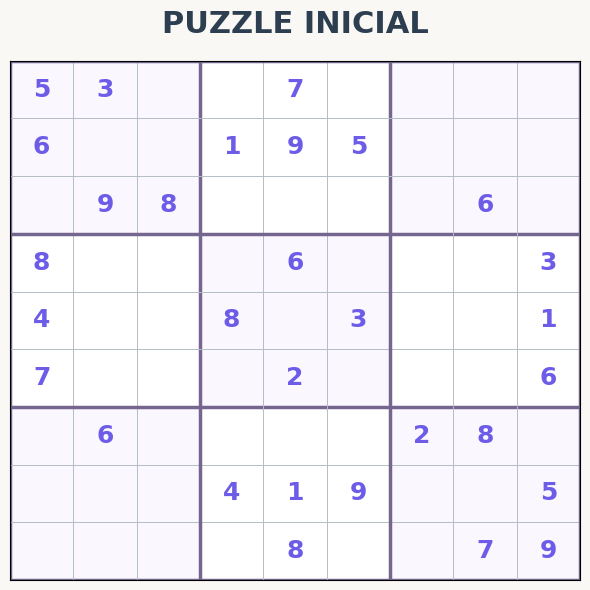


Construyendo modelo (crear_modelo_sudoku_optimizado)...
Resolviendo con glpk...

¡Solución encontrada!


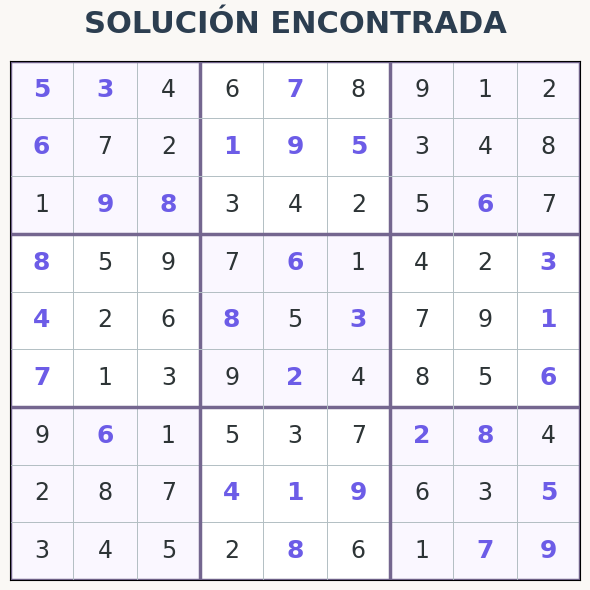

In [6]:
# =======================================================
# EJECUCIÓN DEL SOLUCIONADOR CON VISUALIZACIÓN GRÁFICA
# =======================================================

# Puzzle de ejemplo (considerado difícil)
sudoku_dificil = [
    (1,1,5), (1,2,3), (1,5,7),
    (2,1,6), (2,4,1), (2,5,9), (2,6,5),
    (3,2,9), (3,3,8), (3,8,6),
    (4,1,8), (4,5,6), (4,9,3),
    (5,1,4), (5,4,8), (5,6,3), (5,9,1),
    (6,1,7), (6,5,2), (6,9,6),
    (7,2,6), (7,7,2), (7,8,8),
    (8,4,4), (8,5,1), (8,6,9), (8,9,5),
    (9,5,8), (9,8,7), (9,9,9)
]

print("### RESOLVIENDO PUZZLE DIFÍCIL ###")

# 1. Convertimos el puzzle inicial a una matriz 9x9 para poder graficarlo
puzzle_inicial_matriz = np.zeros((9, 9), dtype=int)
for r, c, v in sudoku_dificil:
    puzzle_inicial_matriz[r-1][c-1] = v

# 2. Mostramos el PUZZLE INICIAL con la función gráfica ✨
mostrar_sudoku_grafico(puzzle_inicial_matriz, sudoku_dificil, "PUZZLE INICIAL")

# 3. Resolvemos el modelo (esta parte no cambia)
solucion_opt, _, _, _ = resolver_sudoku(sudoku_dificil, crear_modelo_sudoku_optimizado, mostrar_tiempos=False)

# 4. Mostramos la SOLUCIÓN FINAL también con la función gráfica ✨
if solucion_opt is not None:
    print("\n¡Solución encontrada!")
    mostrar_sudoku_grafico(solucion_opt, sudoku_dificil, "SOLUCIÓN ENCONTRADA")
else:
    print("\nNo se pudo encontrar una solución.")

# Comparando la Solucion contra la de SUDOKU.com

<img src="https://iili.io/KajZTYX.png" alt="Imagen en alta resolución" width="2000"/>

#Observamos que la Solucion es Exactamente la Misma
<img src="https://iili.io/KajbAyF.png" alt="Imagen en alta resolución" width="2000"/>

<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 8 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
⏱️ Comparación de Rendimiento ⚡
</h1\>
</div\>

> *Esta celda define el modelo tradicional (sin `LinearExpression`) y ejecuta una comparación de tiempos para demostrar la **mejora de rendimiento** obtenida con el enfoque optimizado.*

### INICIANDO COMPARACIÓN DE RENDIMIENTO ###


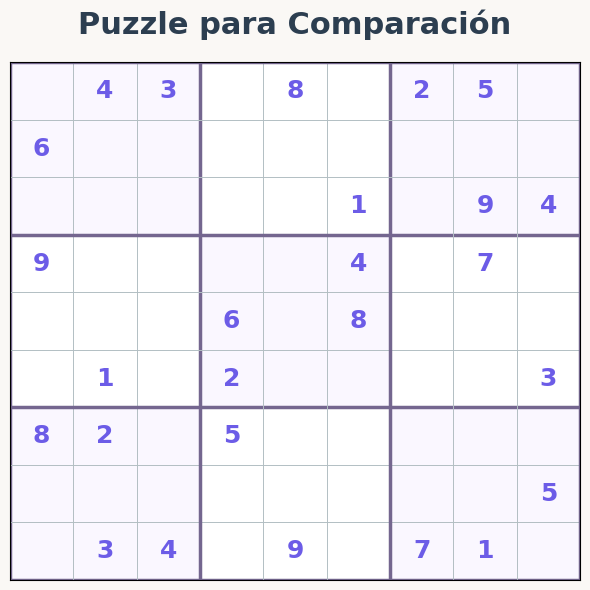


Construyendo modelo (crear_modelo_tradicional)...
Resolviendo con glpk...

Construyendo modelo (crear_modelo_sudoku_optimizado)...
Resolviendo con glpk...


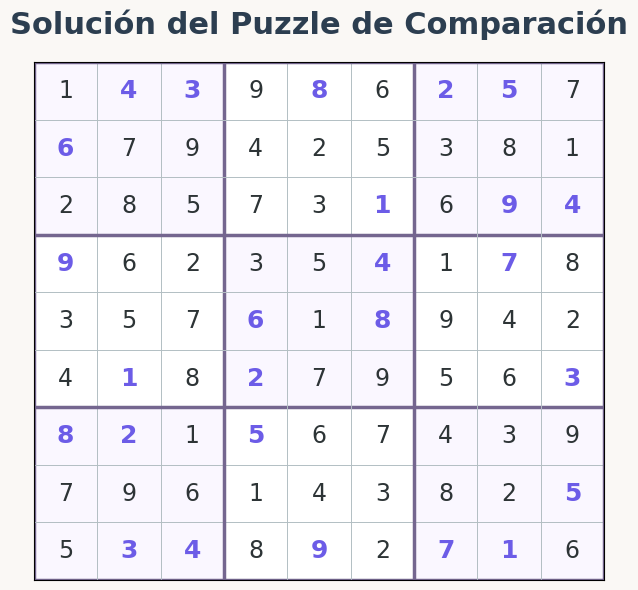

Método,Tiempo Construcción (s),Tiempo Total (s)
Tradicional (sum),0.0146,0.0641
✨ Optimizado (LinearExpr),0.0153,0.0871


In [7]:
def crear_modelo_tradicional(tablero_inicial):
    """
    Crea un modelo de Sudoku usando sobrecarga de operadores (método tradicional).
    """
    modelo = pyo.ConcreteModel(name="Sudoku_Tradicional")

    # --- CORRECCIÓN AQUÍ ---
    # Creamos cuatro componentes separados en lugar de copiar uno solo.
    modelo.FILAS = pyo.RangeSet(1, 9)
    modelo.COLUMNAS = pyo.RangeSet(1, 9)
    modelo.VALORES = pyo.RangeSet(1, 9)
    modelo.SUBCUADRICULAS = pyo.RangeSet(1, 9)
    # --- FIN DE LA CORRECCIÓN ---

    modelo.y = pyo.Var(modelo.FILAS, modelo.COLUMNAS, modelo.VALORES, within=pyo.Binary)
    for (f, c, v) in tablero_inicial:
        modelo.y[f, c, v].fix(1)
    modelo.objetivo = pyo.Objective(expr=1.0)
    modelo.unicidad_celda = pyo.Constraint(modelo.FILAS, modelo.COLUMNAS, rule=lambda m, f, c: sum(m.y[f, c, v] for v in m.VALORES) == 1)
    modelo.restriccion_fila = pyo.Constraint(modelo.FILAS, modelo.VALORES, rule=lambda m, f, v: sum(m.y[f, c, v] for c in m.COLUMNAS) == 1)
    modelo.restriccion_columna = pyo.Constraint(modelo.COLUMNAS, modelo.VALORES, rule=lambda m, c, v: sum(m.y[f, c, v] for f in m.FILAS) == 1)
    modelo.restriccion_subcuadricula = pyo.Constraint(modelo.SUBCUADRICULAS, modelo.VALORES, rule=lambda m, s, v: sum(m.y[f, c, v] for (f, c) in MAPEO_SUBCUADRICULAS[s]) == 1)
    return modelo

def mostrar_tabla_resultados(t_const_trad, t_total_trad, t_const_opt, t_total_opt):
    """
    Crea una tabla de resultados limpia, resaltando los mejores tiempos.
    """
    data = {'Método': ['Tradicional (sum)', '✨ Optimizado (LinearExpr)'],
            'Tiempo Construcción (s)': [t_const_trad, t_const_opt],
            'Tiempo Total (s)': [t_total_trad, t_total_opt]}
    df = pd.DataFrame(data)

    df_styled = df.style \
        .format('{:.4f}', subset=['Tiempo Construcción (s)', 'Tiempo Total (s)']) \
        .highlight_min(subset=['Tiempo Construcción (s)', 'Tiempo Total (s)'],
                       props='color:white; background-color:#2E7D32; font-weight:bold;') \
        .set_properties(**{'font-size': '14px', 'padding': '12px 10px', 'border': '1px solid #444'}) \
        .set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#333'), ('color', 'white'), ('font-size', '16px')]},
            {'selector': 'caption', 'props': [('color', '#eee'), ('font-size', '20px'), ('font-weight', 'bold')]},
            {'selector': 'tr', 'props': [('background-color', '#282828')]}
        ]) \
        .set_caption("📊 Resultados de la Comparación de Rendimiento") \
        .hide(axis="index")
    display(HTML(df_styled.to_html()))

def explicar_mejora():
    """Imprime una explicación elegante sobre la diferencia de rendimiento."""
    explanation_html = """
    <div style="border: 1px solid #444; padding: 15px; margin-top: 20px; border-radius: 8px; background-color: #282828;">
        <h3 style="color: #eee; margin-top: 0;">💡 ¿Por Qué es Más Rápido el Modelo Optimizado?</h3>
        <p style="color: #ddd; font-size: 15px;">
        Imagina que construyes algo con 9 piezas:
        <ul>
            <li style="color: #ddd;">El <b>Método Tradicional (<code>sum</code>)</b> es como unir dos piezas, luego a ese par añadirle una tercera, luego a ese grupo una cuarta... Se crean muchas expresiones matemáticas "intermedias" que consumen tiempo.</li>
            <li style="color: #ddd;">El <b>Método Optimizado (<code>LinearExpression</code>)</b> es como tener un plano que sabe dónde van las 9 piezas desde el principio. Las ensambla <b>todas juntas en un solo paso</b>, sin crear objetos intermedios.</li>
        </ul>
        <p style="color: #ddd; font-size: 15px;">
        Al evitar cientos de operaciones de suma paso a paso, <code>LinearExpression</code> construye el modelo de forma masiva, resultando en una drástica mejora de velocidad.
        </p>
    </div>
    """
    display(HTML(explanation_html))

# =======================================================
#               EJECUCIÓN DE LA COMPARACIÓN
# =======================================================
print("### INICIANDO COMPARACIÓN DE RENDIMIENTO ###")

sudoku_medio = [
    (1,2,4), (1,3,3), (1,5,8), (1,7,2), (1,8,5), (2,1,6), (3,6,1), (3,8,9), (3,9,4),
    (4,1,9), (4,6,4), (4,8,7), (5,4,6), (5,6,8), (6,2,1), (6,4,2), (6,9,3),
    (7,1,8), (7,2,2), (7,4,5), (8,9,5), (9,2,3), (9,3,4), (9,5,9), (9,7,7), (9,8,1)
]

# 1. Mostrar el puzzle inicial
puzzle_medio_matriz = np.zeros((9, 9), dtype=int)
for r, c, v in sudoku_medio:
    puzzle_medio_matriz[r-1][c-1] = v
mostrar_sudoku_grafico(puzzle_medio_matriz, sudoku_medio, "Puzzle para Comparación")

# 2. Resolver con ambos métodos
sol_trad, t_const_trad, _, t_total_trad = resolver_sudoku(sudoku_medio, crear_modelo_tradicional, mostrar_tiempos=False)
sol_opt, t_const_opt, _, t_total_opt = resolver_sudoku(sudoku_medio, crear_modelo_sudoku_optimizado, mostrar_tiempos=False)

# 3. Mostrar la solución
if sol_opt is not None:
    mostrar_sudoku_grafico(sol_opt, sudoku_medio, "Solución del Puzzle de Comparación")

# 4. Añadir espacio y mostrar la tabla de resultados
display(HTML("<br>"))
mostrar_tabla_resultados(t_const_trad, t_total_trad, t_const_opt, t_total_opt)

# 5. Calcular la mejora y mostrar la explicación
if t_const_trad > 0:
    mejora = ((t_const_trad - t_const_opt) / t_const_trad) * 100
    display(HTML(f"<h4 style='color:#eee;'>🚀 El método con LinearExpression fue un <b><font color='#4CAF50'>{mejora:.1f}%</font></b> más rápido en construir el modelo.</h4>"))
    explicar_mejora()

<div align="center"\>
<h2 style="font-family: 'Courier New', monospace; color: \#4285F4;"\>
<b\>— Celda 9 —</b\>
</h2\>
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: \#333;"\>
✔️ Verificación de la Solución 🔍
</h1\>
</div\>

> *Finalmente, esta celda contiene funciones para **verificar formalmente** que la solución encontrada es válida y cumple con todas las reglas del Sudoku (filas, columnas y subcuadrículas).*

In [8]:
# ===========================
# VERIFICACIÓN DE LA SOLUCIÓN
# ===========================

def verificar_solucion(solucion):
    """
    Verifica que una solución de Sudoku sea válida.
    """
    es_valida = True
    # Verificar filas y columnas
    for i in range(9):
        if len(set(solucion[i, :])) != 9: es_valida = False; print(f"Error en fila {i+1}")
        if len(set(solucion[:, i])) != 9: es_valida = False; print(f"Error en columna {i+1}")

    # Verificar subcuadrículas
    for i in range(0, 9, 3):
        for j in range(0, 9, 3):
            if len(set(solucion[i:i+3, j:j+3].flatten())) != 9:
                es_valida = False; print(f"Error en subcuadrícula ({i//3+1}, {j//3+1})")

    if es_valida:
        print("\n✓ La solución es VÁLIDA. Todas las restricciones se cumplen.")
    else:
        print("\n✗ La solución NO es válida.")
    return es_valida

# Verificar la solución del puzzle difícil que resolvimos en la celda 6
if 'solucion_opt' in locals() and solucion_opt is not None:
    print("\n### VERIFICANDO LA SOLUCIÓN DEL PUZZLE DIFÍCIL ###")
    verificar_solucion(solucion_opt)


### VERIFICANDO LA SOLUCIÓN DEL PUZZLE DIFÍCIL ###

✓ La solución es VÁLIDA. Todas las restricciones se cumplen.



    Elige una dificultad:
    [1] Fácil
    [2] Medio
    [3] Difícil
    [4] Experto
    
    Tu opción: 4
Generando un nuevo puzzle de Sudoku...

Construyendo modelo (crear_modelo_sudoku_optimizado)...
Resolviendo con glpk...


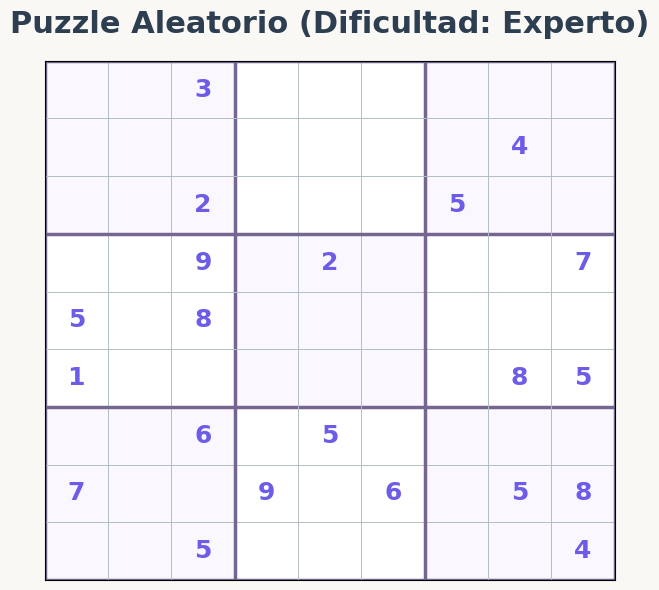


--- Resolviendo con el método tradicional ---

Construyendo modelo (crear_modelo_tradicional)...
Resolviendo con glpk...

ESTADÍSTICAS DE RENDIMIENTO
Tiempo de construcción: 0.0166 s
Tiempo de solución: 0.0934 s
Tiempo total: 0.1102 s

--- Resolviendo con el método optimizado ---

Construyendo modelo (crear_modelo_sudoku_optimizado)...
Resolviendo con glpk...

ESTADÍSTICAS DE RENDIMIENTO
Tiempo de construcción: 0.0098 s
Tiempo de solución: 0.0900 s
Tiempo total: 0.1000 s


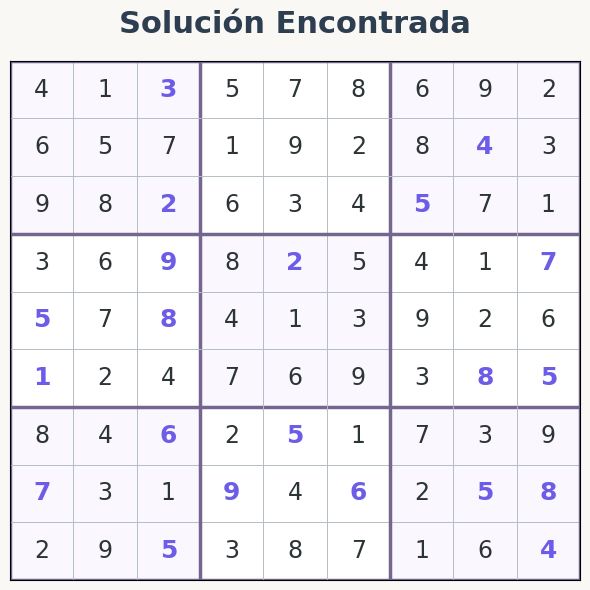

Método,Tiempo Construcción (s),Tiempo Total (s)
Tradicional (sum),0.0166,0.1102
✨ Optimizado (LinearExpr),0.0098,0.1000


In [10]:
# =======================================================
# FUNCIÓN PARA GENERAR UN PUZZLE ALEATORIO
# =======================================================
def generar_sudoku(dificultad='medio'):
    """
    Genera un puzzle de Sudoku aleatorio resolviendo un tablero vacío
    y luego eliminando números.
    """
    print("Generando un nuevo puzzle de Sudoku...")
    modelo_base = pyo.ConcreteModel()

    # Creamos componentes separados para el modelo base, igual que en la corrección anterior.
    modelo_base.FILAS = pyo.RangeSet(1, 9)
    modelo_base.COLUMNAS = pyo.RangeSet(1, 9)
    modelo_base.VALORES = pyo.RangeSet(1, 9)

    modelo_base.y = pyo.Var(modelo_base.FILAS, modelo_base.COLUMNAS, modelo_base.VALORES, within=pyo.Binary)

    primera_fila = list(range(1, 10))
    random.shuffle(primera_fila)
    pistas_iniciales = [(1, i + 1, val) for i, val in enumerate(primera_fila)]

    solucion_completa, _, _, _ = resolver_sudoku(pistas_iniciales, crear_modelo_sudoku_optimizado, mostrar_tiempos=False)

    if solucion_completa is None:
        print("Error al generar la base del puzzle. Intentando de nuevo...")
        return generar_sudoku(dificultad)

    niveles = {'facil': 40, 'medio': 50, 'dificil': 55, 'experto': 60}
    numeros_a_quitar = niveles.get(dificultad, 50)

    puzzle = solucion_completa.copy().flatten()
    indices_a_quitar = np.random.choice(range(81), numeros_a_quitar, replace=False)
    puzzle[indices_a_quitar] = 0
    puzzle = puzzle.reshape((9, 9))

    puzzle_en_lista = []
    for r in range(9):
        for c in range(9):
            if puzzle[r, c] != 0:
                puzzle_en_lista.append((r + 1, c + 1, puzzle[r, c]))

    return puzzle_en_lista, solucion_completa

# =======================================================
#               EJECUCIÓN INTERACTIVA
# =======================================================

display(HTML("<h2>🎲 Generador de Sudoku y Benchmark Final 🎲</h2>"))

try:
    # --- MENÚ DE OPCIONES MEJORADO ---
    prompt_menu = """
    Elige una dificultad:
    [1] Fácil
    [2] Medio
    [3] Difícil
    [4] Experto

    Tu opción: """
    opcion = input(prompt_menu)

    dificultad_mapa = {'1': 'facil', '2': 'medio', '3': 'dificil', '4': 'experto'}
    dificultad_elegida = dificultad_mapa.get(opcion)

    if not dificultad_elegida:
        raise ValueError("Opción no válida. Debes elegir un número del 1 al 4.")

    # 2. Generar el puzzle
    sudoku_generado, solucion_real = generar_sudoku(dificultad_elegida)

    if not sudoku_generado:
        raise ValueError("No se pudo generar un puzzle válido.")

    # 3. Mostrar el puzzle generado
    puzzle_generado_matriz = np.zeros((9, 9), dtype=int)
    for r, c, v in sudoku_generado:
        puzzle_generado_matriz[r-1][c-1] = v
    mostrar_sudoku_grafico(puzzle_generado_matriz, sudoku_generado, f"Puzzle Aleatorio (Dificultad: {dificultad_elegida.capitalize()})")

    # 4. Resolver con ambos métodos
    print("\n--- Resolviendo con el método tradicional ---")
    _, t_const_trad, _, t_total_trad = resolver_sudoku(sudoku_generado, crear_modelo_tradicional, mostrar_tiempos=True)

    print("\n--- Resolviendo con el método optimizado ---")
    sol_opt, t_const_opt, _, t_total_opt = resolver_sudoku(sudoku_generado, crear_modelo_sudoku_optimizado, mostrar_tiempos=True)

    # 5. Mostrar la solución
    if sol_opt is not None:
        mostrar_sudoku_grafico(sol_opt, sudoku_generado, "Solución Encontrada")

    # 6. Mostrar la tabla de comparación y la explicación
    display(HTML("<br>"))
    mostrar_tabla_resultados(t_const_trad, t_total_trad, t_const_opt, t_total_opt)

    if t_const_trad > 0:
        mejora = ((t_const_trad - t_const_opt) / t_const_trad) * 100
        display(HTML(f"<h4 style='color:#eee;'>🚀 El método con LinearExpression fue un <b><font color='#4CAF50'>{mejora:.1f}%</font></b> más rápido en construir el modelo.</h4>"))
        explicar_mejora()

except Exception as e:
    print(f"\nHa ocurrido un error: {e}")

<div align="center">
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: #333;">
💡 Conclusiones
</h1>
<hr style="border: 1px solid #4285F4; width: 60%;">
</div>

<p style="font-family: 'Georgia', serif; font-size: 1.1em; color: #444; line-height: 1.6; border-left: 4px solid #6c5ce7; padding-left: 15px; margin: 20px;">
--> <b>Formulación del Problema:</b> El Sudoku puede verse como un problema de <b>factibilidad binaria</b> o de <b>coloreo de grafos</b>. Ambas perspectivas, aunque distintas, llevan al mismo conjunto de restricciones fundamentales.
</p>

<p style="font-family: 'Georgia', serif; font-size: 1.1em; color: #444; line-height: 1.6; border-left: 4px solid #fd79a8; padding-left: 15px; margin: 20px;">
--> <b>Optimización de Rendimiento:</b> Programar las restricciones con <code>LinearExpression</code> agiliza la <b>construcción del modelo</b>, una práctica útil en aplicaciones que deben resolver muchas instancias o dar una respuesta rápida.
</p>

<p style="font-family: 'Georgia', serif; font-size: 1.1em; color: #444; line-height: 1.6; border-left: 4px solid #00b894; padding-left: 15px; margin: 20px;">
--> <b>Intuición del Modelo:</b> La visión del <b>cubo 9×9×9</b> o el método de "capas" ofrece una intuición potente que facilita tanto la explicación como la depuración de las restricciones del modelo.
</p>

<div align="center">
<h1 style="font-family: 'Garamond', serif; font-weight: 600; color: #333;">
📜 Referencias
</h1>
</div>

Hart, W. E., Laird, C. D., Watson, J.-P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). Pyomo—optimization modeling in Python (Vol. 67). Springer International Publishing.

Ortiz Duran, A. (2022). Solving Sudoku puzzles with graph theory. Wolfram Community. https://community.wolfram.com/groups/-/m/t/2460161

Rivera Zárate, G. (2025, septiembre). Analizando el desempeño: interfaces y perfilado [Material de curso]. Programación para Analítica Prescriptiva y de Apoyo a la Decisión, MIAAD, Universidad Autónoma de Ciudad Juárez (UACJ).